In [1]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import sys
import warnings
warnings.simplefilter("ignore")
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [2]:
def split_data(df, split_date=None, start_date=None, end_date=None, with_val=False, val_size=0, test_size=1):
    if with_val:
        df_train = df.iloc[:-(val_size+test_size)]
        df_valid = df.iloc[-(val_size+test_size):-test_size]
        df_test = df.iloc[-test_size:]
        return df_train, df_valid, df_test
    else:
        train = df[df.date <= split_date]
        test = df[df.date > split_date]
        if start_date is not None:
            train = train[train.date >= start_date]
        if end_date is not None:
            test = test[test.date <= end_date]
        return train, test

In [3]:
df_risk = pd.read_csv('data/df_risk.csv')
df_train_all, df_test_all = split_data(df_risk, split_date='2024-12-02')

In [4]:
df_train_all

,date,MOEX,MOEXBC,RTSI,USD,EUR,BRENT,y_0_25,y_0_5,y_0_75,...,GAZP,GMKN,LKOH,MGNT,MTSS,NVTK,ROSN,SBER,TRNFP,YNDX
0,2021-01-12,3471.65,22899.91,1484.96,74.5157,90.8123,56.580002,4.16,4.18,4.23,...,228.69,25934.00,5721.0,5450.5,334.20,1401.0,474.40,289.99,145100.0,5121.8
1,2021-01-13,3470.26,22925.91,1486.77,74.2663,90.3227,56.060001,4.20,4.23,4.29,...,226.80,25976.00,5755.0,5410.0,331.90,1425.6,485.95,283.78,146000.0,5079.8
2,2021-01-14,3490.85,23017.13,1500.58,73.5264,89.7831,56.419998,4.17,4.22,4.28,...,228.86,26432.00,5937.0,5375.5,337.35,1438.0,505.00,284.79,149250.0,5077.4
3,2021-01-19,3443.23,22567.45,1470.63,73.9735,89.3304,55.900002,4.09,4.15,4.23,...,223.15,25826.00,5892.0,5183.5,331.10,1377.2,510.70,278.19,148000.0,5008.8
4,2021-01-20,3466.80,22743.47,1486.90,73.7243,89.2064,56.080002,4.13,4.16,4.21,...,224.30,26550.00,5864.0,5161.5,332.20,1388.6,510.65,279.80,148550.0,5170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2024-11-19,2630.51,16744.57,828.38,99.9430,105.4606,73.309998,21.51,21.49,21.42,...,125.49,111.00,6842.0,4491.5,186.50,875.0,459.70,240.59,1166.5,NaN
541,2024-11-20,2596.89,16522.91,816.29,100.0348,105.7338,72.809998,21.87,21.84,21.76,...,121.89,108.28,6798.5,4424.0,183.50,847.8,449.25,237.05,1144.0,NaN
542,2024-11-21,2568.60,16404.60,803.70,100.2192,105.8090,74.230003,21.93,21.87,21.77,...,124.10,109.32,6938.5,4582.5,180.05,864.8,458.95,240.47,1092.0,NaN
543,2024-11-26,2464.35,15784.91,738.93,103.7908,108.8705,72.809998,22.89,22.73,22.52,...,114.50,104.08,6869.5,4150.0,169.90,807.8,450.80,223.16,1031.0,NaN


In [5]:
df_test_all

,date,MOEX,MOEXBC,RTSI,USD,EUR,BRENT,y_0_25,y_0_5,y_0_75,...,GAZP,GMKN,LKOH,MGNT,MTSS,NVTK,ROSN,SBER,TRNFP,YNDX
545,2024-12-03,2539.64,16361.60,753.42,107.1758,112.8019,73.620003,23.27,23.04,22.80,...,121.48,110.40,6771.0,4559.5,171.85,824.0,490.50,230.80,966.0,NaN
546,2024-12-04,2485.62,16009.74,751.20,106.1878,112.0200,72.309998,23.62,23.36,23.07,...,115.30,104.20,6720.5,4446.0,166.15,800.0,473.10,224.55,919.5,NaN
547,2024-12-05,2510.83,16187.17,765.08,104.2361,110.2041,72.089996,23.58,23.30,23.00,...,116.63,108.16,6841.0,4478.0,171.05,830.4,488.20,233.48,942.5,NaN
548,2024-12-10,2522.75,16279.42,794.46,99.3759,105.0996,72.190002,22.85,22.65,22.42,...,114.70,103.60,6894.0,4521.5,170.25,811.6,484.60,230.82,952.5,NaN
549,2024-12-11,2512.54,16213.55,766.44,100.0324,106.2024,73.519997,23.15,22.95,22.73,...,115.16,104.10,6895.5,4529.0,169.65,810.0,488.75,234.19,953.5,NaN
550,2024-12-12,2492.63,16098.81,755.39,103.2707,108.5588,73.410004,22.88,22.69,22.46,...,113.10,100.30,6862.5,4443.0,168.65,791.2,485.45,229.02,927.0,NaN
551,2024-12-17,2377.15,15268.05,727.06,102.9125,108.7016,73.190002,22.67,22.55,22.38,...,107.26,94.98,6290.5,4340.0,163.90,771.6,480.65,226.50,901.0,NaN
552,2024-12-18,2409.35,15457.21,738.50,102.9979,108.3444,73.389999,22.41,22.35,22.24,...,108.05,95.66,6375.0,4432.5,166.70,784.8,487.70,230.15,923.0,NaN
553,2024-12-19,2416.45,15485.36,736.06,102.7763,108.5083,72.879997,20.28,20.25,20.19,...,107.16,95.70,6294.0,4415.5,171.25,814.4,506.15,229.00,922.0,NaN
554,2024-12-24,2690.96,17290.96,848.79,101.6143,105.2512,73.580002,18.33,18.33,18.30,...,121.70,104.96,6833.0,4945.5,194.80,915.4,572.70,264.34,1054.0,NaN


#функции

In [10]:
#df_train_all_pca = df_train_all.pct_change().dropna(axis=0)
#df_test_all_pca = df_test_all.pct_change().dropna(axis=0)
#df_risk_pca = df_risk.pct_change().dropna(axis=0)

In [44]:
import importlib 
import stoch_models
import model_automodel
import instrument_and_portf
importlib.reload(stoch_models)
importlib.reload(model_automodel)
importlib.reload(instrument_and_portf)

<module 'instrument_and_portf' from '/mnt/c/Users/User/Desktop/ML_DL_knowledge/RiskManagement/project2/rm_project_2/instrument_and_portf.py'>

In [6]:
# from simulation_classes import Stoch_Models, AutoModel
from functions.stoch_models import Stoch_Models
from functions.model_automodel import AutoModel  
from functions.instrument_and_portf import Portfolio

#не функции

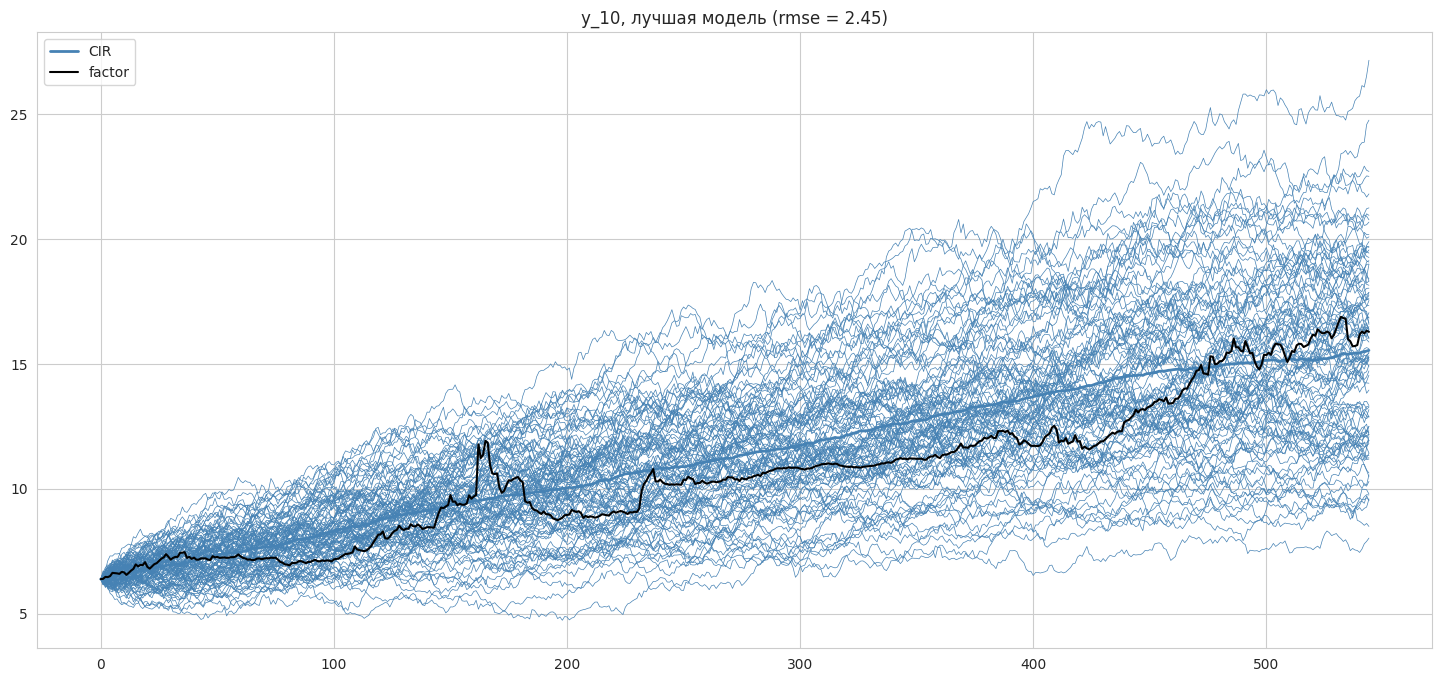

In [7]:
f_col = 'y_10'
sm = Stoch_Models(factor_name=f_col,
                 value_train = df_train_all[f_col].values, value_test = df_test_all[f_col].values,
                 t_train = list(df_train_all.index), t_test = list(df_test_all.index),
                 models=['m1', 'm2', 'm3', 'm4'], N_traj=100)
sm.choose_model(print_metric=0, plot_all=0, metric='rmse')

In [8]:
def semaphore(p):
    if p > 0.05:
        return "green"
    elif p > 0.0001:
        return "yellow"
    else:
        return "red"


def norm_percenile(x, level):
    return np.mean(x) + ss.norm.ppf(level) * np.std(x)

In [9]:
stonks = df_risk[['GAZP', 'GMKN', 'LKOH', 'MGNT', 'MTSS', 'NVTK', 'ROSN',
                  'SBER', 'TRNFP', 'YNDX', 'MOEXBC']]

features_tools = df_risk[['GAZP', 'GMKN', 'LKOH', 'MGNT', 'MTSS', 'NVTK', 'ROSN',
                       'SBER', 'TRNFP', 'YNDX', 'MOEXBC', 'SU26207RMFS9',
                       'SU26207RMFS9', 'SU26212RMFS9', 'SU26224RMFS4', 'SU26225RMFS1',
                       'SU26228RMFS5', 'USD', 'EUR']]

features_risk = df_risk[['y_0_25', 'y_0_5', 'y_0_75', 'y_1', 'y_2', 'y_3',
                       'y_5', 'y_7', 'y_10', 'y_15', 'y_20', 'y_30',
                       "BRENT", 'MOEXBC', 'RTSI']]

In [10]:
df_train_all = df_train_all.ffill() # чтоы не было  Input contains NaN.
df_test_all = df_test_all.ffill()

In [11]:
df_train_all = df_train_all.drop(columns = 'YNDX')
df_test_all = df_test_all.drop(columns = 'YNDX')

In [12]:
results = []
instrument_models = {}

# for f in features_tools.columns:
for f in [x for x in features_tools.columns if 'YNDX' not in x]:
    m = AutoModel().fit(df_train_all[features_risk.columns], df_train_all[f])
    score = m.predict(df_train_all)
    score_test = m.predict(df_test_all)
    results.append(
        {
            "tool": f,
            "n_components": m.n_components,
            "r2_train": r2_score(df_train_all[f], score),
            "r2_test": r2_score(df_test_all[f], score_test),
        }
    )
    instrument_models[f] = m
results = pd.DataFrame(results)
results

,tool,n_components,r2_train,r2_test
0,GAZP,2,0.787898,-5.860813
1,GMKN,10,0.919903,-248701.395239
2,LKOH,5,0.945284,0.766631
3,MGNT,2,0.370684,-13.438308
4,MTSS,3,0.640783,-27.182152
5,NVTK,2,0.692260,-25.597685
6,ROSN,2,0.926506,0.136351
7,SBER,3,0.907202,0.772050
8,TRNFP,5,0.770345,-42998.926036
9,MOEXBC,10,1.000000,1.000000


In [13]:
init_tools = {
    "GAZP": 1_000_000,
    "GMKN": 1_000_000,
    "LKOH": 1_000_000,
    "MGNT": 1_000_000,
    "MTSS": 1_000_000,
    "NVTK": 1_000_000,
    "ROSN": 1_000_000,
    "SBER": 1_000_000,
    "TRNFP": 1_000_000,
    "YNDX": 1_000_000,
    "SU26207RMFS9": 10_000_000,
    "SU26212RMFS9": 10_000_000,
    "SU26224RMFS4": 10_000_000,
    "SU26225RMFS1": 10_000_000,
    "SU26228RMFS5": 10_000_000,
    "USD": 100_000_000,
    "EUR": 100_000_000,
}

In [ ]:
# import copy


# class Instrument:
#     def __init__(self, name, count, price):
#         self.name = name
#         self.cnt = count
#         self.price = price

#     @property
#     def cost(self):
#         return self.price * self.cnt

#     def __repr__(self):
#         return "{}({} x {})".format(self.name, self.cnt, self.price)


# class Portfolio:
#     def __init__(self, tools_with_money, init_prices):
#         total = sum(tools_with_money.values())
#         self.tools_target = {k: v / total for k, v in tools_with_money.items()}
#         self.tools = {
#             k: Instrument(k, tools_with_money[k] / init_prices[k], init_prices[k]) for k, v in self.tools_target.items()
#         }

#     @property
#     def cost(self):
#         return sum([x.cost for x in self.tools.values()])

#     def _tool_rate(self):
#         total_cost = self.cost
#         return {k: v.cost / total_cost for k, v in self.tools.items()}

#     def __getitem__(self, k):
#         return self.tools[k]

#     def rebalancing(self, new_prices):
#         old_cost = self.cost
#         old_prices = {k: self[k].price for k in self.tools}
#         for k, p in new_prices.items():
#             self[k].price = p
#         new_cost = self.cost
#         for k in self.tools:
#             self[k].cnt *= new_cost / old_cost * old_prices[k] / new_prices[k]

#         for k, v in self._tool_rate().items():
#             assert np.abs(v - self.tools_target[k]) < 0.00001

#     def new_cost(self, new_prices):
#         new_cost = sum([v.cnt * new_prices[k] for k, v in self.tools.items()])
#         return new_cost

#     def copy(self):
#         return copy.deepcopy(self)


In [31]:
df_risk

,date,MOEX,MOEXBC,RTSI,USD,EUR,BRENT,y_0_25,y_0_5,y_0_75,...,GAZP,GMKN,LKOH,MGNT,MTSS,NVTK,ROSN,SBER,TRNFP,YNDX
0,2021-01-12,3471.65,22899.91,1484.96,74.5157,90.8123,56.580002,4.16,4.18,4.23,...,228.69,25934.00,5721.0,5450.5,334.20,1401.0,474.40,289.99,145100.0,5121.8
1,2021-01-13,3470.26,22925.91,1486.77,74.2663,90.3227,56.060001,4.20,4.23,4.29,...,226.80,25976.00,5755.0,5410.0,331.90,1425.6,485.95,283.78,146000.0,5079.8
2,2021-01-14,3490.85,23017.13,1500.58,73.5264,89.7831,56.419998,4.17,4.22,4.28,...,228.86,26432.00,5937.0,5375.5,337.35,1438.0,505.00,284.79,149250.0,5077.4
3,2021-01-19,3443.23,22567.45,1470.63,73.9735,89.3304,55.900002,4.09,4.15,4.23,...,223.15,25826.00,5892.0,5183.5,331.10,1377.2,510.70,278.19,148000.0,5008.8
4,2021-01-20,3466.80,22743.47,1486.90,73.7243,89.2064,56.080002,4.13,4.16,4.21,...,224.30,26550.00,5864.0,5161.5,332.20,1388.6,510.65,279.80,148550.0,5170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,2024-12-18,2409.35,15457.21,738.50,102.9979,108.3444,73.389999,22.41,22.35,22.24,...,108.05,95.66,6375.0,4432.5,166.70,784.8,487.70,230.15,923.0,NaN
553,2024-12-19,2416.45,15485.36,736.06,102.7763,108.5083,72.879997,20.28,20.25,20.19,...,107.16,95.70,6294.0,4415.5,171.25,814.4,506.15,229.00,922.0,NaN
554,2024-12-24,2690.96,17290.96,848.79,101.6143,105.2512,73.580002,18.33,18.33,18.30,...,121.70,104.96,6833.0,4945.5,194.80,915.4,572.70,264.34,1054.0,NaN
555,2024-12-26,2766.57,17814.68,878.30,99.6125,103.9416,73.260002,17.49,17.59,17.64,...,126.89,109.66,7003.0,5174.0,196.00,949.8,579.10,269.56,1126.5,NaN


In [ ]:
# class PortfolioSimulation:
#     def __init__(self, init_tools, window_size, t):
#         features_tools = sorted(list(init_tools.keys()))
#         p = Portfolio(init_tools, df_risk.iloc[0][features_tools].to_dict())
#         portfolio_prices = []
#         for i, row in tqdm(df_risk.iterrows(), total=len(df_risk)):
#             p.rebalancing(row[features_tools].to_dict())
#             portfolio_prices.append(
#                 {
#                     "date": i,
#                     "price": p.cost,
#                 }
#             )
#         self.portfolio_prices = pd.DataFrame(portfolio_prices)
#         self.portfolio_prices["price_change"] = self.portfolio_prices["price"].pct_change()

#         instrument_simulations = [None] * len(features_tools)
#         # Получаем симуляции для не-стоков
#         for fi, f in tqdm(enumerate(features_tools), total=len(features_tools)):
#             if f in stonks.columns:
#                 continue
#             m = instrument_models[f]
#             pca_df = m.predict_pca(df_risk_restricted)
#             simulations = []
#             for i in range(len(pca_df) - window_size - t):
#                 pca_sim = Stoch_Models.future_simulation(pca_df[i : i + window_size], t)
#                 simulations.append(m.predict_lr(pca_sim))
#             instrument_simulations[fi] = simulations
#         # Получаем симуляции для стоков
#         if any([x is None for x in instrument_simulations]):
#             stock_df = df_risk_restricted[[f for f in features_tools if f in stonks.columns]].values
#             simulations = []
#             for i in range(len(stock_df) - window_size - t):
#                 stock_sim = Stoch_Models.future_simulation(stock_df[i : i + window_size], t)
#                 simulations.append(stock_sim)
#             simulations = np.array(simulations)
#             stock_i = 0
#             for fi, f in enumerate(features_tools):
#                 if f in stonks.columns:
#                     instrument_simulations[fi] = simulations[:, :, stock_i]
#                     stock_i += 1

#         assert all([x is not None for x in instrument_simulations])
#         instrument_simulations = np.array(instrument_simulations)

#         portfolio_prices_simulations = []
#         df_ = df_risk.iloc[window_size + t + 1 :].copy()
#         p = Portfolio(init_tools, df_.iloc[0].to_dict())
#         for j, (i, row) in tqdm(enumerate(df_.iterrows()), total=len(df_)):
#             p.rebalancing(row[features_tools])
#             p_sim = []
#             p_init = p.cost
#             # симуляции по всем инструментам за конкретный день
#             new_prices = np.multiply(instrument_simulations[:, j, :].T, row[features_tools].values)  # N, tools
#             new_prices = row[features_tools].values + new_prices
#             for sim in new_prices:
#                 p_sim.append(p.new_cost({k: v for k, v in zip(features_tools, sim)}) / p_init - 1)
#             portfolio_prices_simulations.append(
#                 {
#                     "date": i,
#                     "price_change": p_sim,
#                 }
#             )

#         self.portfolio_prices_simulations = pd.DataFrame(portfolio_prices_simulations)

#         self.portfolio_prices_simulations["var_99"] = -self.portfolio_prices_simulations["price_change"].map(
#             lambda x: -norm_percenile(x, 0.01)
#         )

#         self.portfolio_prices_simulations["es_97,5"] = -self.portfolio_prices_simulations["price_change"].map(
#             lambda x: -(np.array(x)[np.array(x) < norm_percenile(x, 0.025)]).mean()
#         )

#         self.returns = (
#             self.portfolio_prices.dropna(axis=0).iloc[window_size + t :]["price_change"].reset_index(drop=True)
#         )

#     def plot_dynamics(self):
#         self.portfolio_prices.plot(x="date", y="price", figsize=(16, 6))
#         plt.grid()
#         plt.title("Динамика стоимости портфеля")
#         plt.show()

#         self.portfolio_prices.dropna(axis=0).plot(x="date", y="price_change", figsize=(16, 6))
#         plt.grid()
#         plt.title("Динамика изменений стоимости портфеля")
#         plt.show()

#     def calc_test(self, risk, risk_name, risk_color="r*", alpha=0.99):
#         hits = self.returns < self.portfolio_prices_simulations[risk]
#         hit_times = hits.index[hits]
#         print("Риск-фактор:", risk_name)
#         print("Кол-во пробоев:", hits.sum())
#         print("Доля пробоев:", np.round(hits.sum() / hits.size, 4))

#         p_val = ss.binom_test(hits.sum(), hits.size, 1 - alpha, alternative="two-sided")
#         print("Двухсторонняя гипотеза:", np.round(p_val, 4))
#         print("Светофор за тест:", semaphore(p_val))

#         p_val = ss.binom_test(hits.sum(), hits.size, 1 - alpha, alternative="greater")
#         print("Односторонняя гипотеза:", np.round(p_val, 4))
#         print("Светофор за тест:", semaphore(p_val))

#         plt.figure(figsize=(15, 4), facecolor="w")
#         idx = self.portfolio_prices_simulations["date"]
#         plt.plot(idx, self.returns)
#         plt.plot(idx, self.portfolio_prices_simulations[risk], c="r", alpha=0.4, label=risk_name)
#         plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
#         plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
#         plt.axvline(pd.to_datetime(split_date), c="tab:orange", linestyle=":", label="train-test split")
#         plt.plot(idx[hit_times], self.returns[hit_times], risk_color)
#         plt.title("Динамика изменений стоимости портфеля, {}".format(risk_name))
#         plt.ylabel("Процентное изменение")
#         plt.grid()
#         plt.legend()
#         plt.show()

In [39]:
df_risk.set_index('date', inplace=True)
df_risk_restricted = df_risk.iloc[1:]

KeyError: "None of ['date'] are in the columns"

In [43]:
ps = PortfolioSimulation(init_tools, 60, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

  0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 't_train'